In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt

import os
import helper as hp
from configparser import ConfigParser

from ppo_refinement import PPORefinement


In [3]:
reward_flag = 0
lambda_partition = -2.5

In [4]:
def _get_lambda_max(p_tensor_single):
    # Convert tensor to NumPy
    p_numpy = p_tensor_single.detach().cpu().numpy()

    # Determine size n from length = n(n+1)/2
    L = p_numpy.shape[0]
    # Solve n(n+1)/2 = L
    n = int((np.sqrt(8 * L + 1) - 1) / 2)
    assert n * (n + 1) // 2 == L, f"Input length {L} is not valid for any symmetric n x n matrix."

    # Fill upper triangular matrix
    A = np.zeros((n, n))
    idx = 0
    for i in range(n):
        for j in range(i, n):  # Only upper triangle including diagonal
            A[i, j] = p_numpy[idx]
            A[j, i] = p_numpy[idx]  # Mirror to lower triangle
            idx += 1

    # Compute eigenvalues
    eigvals = np.linalg.eigvals(A)

    # Sort by real part descending
    eigvals_sorted = sorted(eigvals, key=lambda x: x.real, reverse=True)

    return eigvals_sorted

def compute_reward(p_tensor_single, n_consider=10):
    lambdas_val = _get_lambda_max(p_tensor_single)

    if reward_flag == 0:
        lambda_max_val = lambdas_val[0]
        penalty = np.maximum(0, lambda_max_val)
        if lambda_max_val > 100:
            lambda_max_val = 100
        r = 1.0 / (1.0 + np.exp(lambda_max_val - lambda_partition))
        r -= penalty
    else:
        considered_avg = sum(lambdas_val[:n_consider]) / n_consider
        r = np.exp(-0.1 * considered_avg) / 2
    # TODO: Right now, we are not using the Incidence part of the reward.

    return r

In [6]:
print('--- Begin PPO refinement strategy')

configs = ConfigParser()
configs.read('configfile.ini')
output_path = configs['PATHS']['output_path']
this_savepath = f'output/ppo-refinement/ppo_sandbox/' 
os.makedirs(this_savepath, exist_ok=True)

ppo_agent = PPORefinement(
    param_dim=10,
    noise_dim=10,
    reward_function=compute_reward,
    min_x_bounds=-10,
    max_x_bounds=10,
    ppo_epochs=10,
    T_horizon=1,
    actor_lr=1e-4,
    critic_lr=1e-4,
    n_trajectories=1,
)

trained_actor, rewards = ppo_agent.train(num_training_iterations=100, output_path=this_savepath)

#print(f"PPO training finished. Rewards log saved to {this_savepath}")


--- Begin PPO refinement strategy
Training on cpu. 1 trajectories per update.


ValueError: Expected parameter loc (Tensor of shape (1, 10)) of distribution Normal(loc: torch.Size([1, 10]), scale: torch.Size([1, 10])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward0>)

In [9]:
with torch.no_grad():
    print(ppo_agent.actor(torch.randn(20)))

(tensor([-0.0853,  0.0058,  0.0147, -0.0552, -0.2510,  0.1967,  0.1654, -0.0563,
         0.0818, -0.0612]), tensor([ 0.0672,  0.0127, -0.0428, -0.1357, -0.0399,  0.0643,  0.0539,  0.1249,
        -0.1591,  0.1332]))


Text(0.5, 1.0, 'PPO Training Rewards')

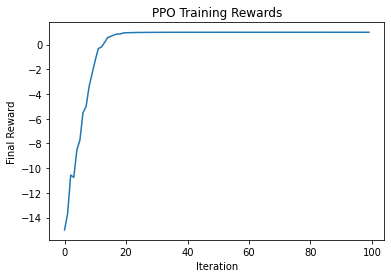

In [6]:
plt.plot(rewards)
plt.xlabel('Iteration')
plt.ylabel('Final Reward')
plt.title('PPO Training Rewards')

In [7]:
import torch
from torch.distributions import Normal

def evaluate_policy_incidence(trained_actor, ppo_agent, num_trials=50):
    T_HORIZON = ppo_agent.T_horizon
    NOISE_DIM = ppo_agent.noise_dim
    N_TRIALS = num_trials
    incidence = 0
    for _ in range(N_TRIALS):
        current_params_in_state = ppo_agent._initialize_current_params_for_state().clone()
        generated_sequence = []
        for _ in range(T_HORIZON):
            noise = torch.randn(NOISE_DIM, device=ppo_agent.device)
            state_1d = torch.cat((noise, current_params_in_state.detach()), dim=0)
            state_batch = state_1d.unsqueeze(0)
            with torch.no_grad():
                mu_raw, log_std_raw = trained_actor(state_batch)
                # For generation, you might want to take the mean (mu_raw) or sample
                # action_raw = mu_raw # Deterministic generation
                action_raw = Normal(mu_raw, torch.exp(log_std_raw)).sample() # Stochastic generation
            
            ode_params = ppo_agent._transform_to_bounded(action_raw)
            current_params_in_state = ode_params.squeeze(0)
            generated_sequence.append(current_params_in_state.cpu().numpy())

        final_generated_params = generated_sequence[-1]
        final_reward_eval = compute_reward(torch.tensor(final_generated_params, device=ppo_agent.device))
        lambda_max = _get_lambda_max(torch.tensor(final_generated_params, device=ppo_agent.device))[0]
        if lambda_max < -2.5:
            incidence += 1
        print(f"Final lambda_max: {lambda_max:.4f}")
        print(f"Final reward: {final_reward_eval:.4f}")
    print(f"Incidence over {N_TRIALS} trials: {incidence}/{N_TRIALS} = {incidence/N_TRIALS:.2f}")

In [8]:
evaluate_policy_incidence(trained_actor, ppo_agent, num_trials=50)

Final lambda_max: -7.1210
Final reward: 0.9903
Final lambda_max: -8.2873
Final reward: 0.9969
Final lambda_max: -8.1637
Final reward: 0.9965
Final lambda_max: -7.4484
Final reward: 0.9930
Final lambda_max: -8.2206
Final reward: 0.9967
Final lambda_max: -7.8938
Final reward: 0.9955
Final lambda_max: -8.0707
Final reward: 0.9962
Final lambda_max: -7.3388
Final reward: 0.9921
Final lambda_max: -8.5687
Final reward: 0.9977
Final lambda_max: -7.9198
Final reward: 0.9956
Final lambda_max: -8.0095
Final reward: 0.9960
Final lambda_max: -8.1965
Final reward: 0.9967
Final lambda_max: -7.9705
Final reward: 0.9958
Final lambda_max: -8.0716
Final reward: 0.9962
Final lambda_max: -7.9326
Final reward: 0.9956
Final lambda_max: -8.0483
Final reward: 0.9961
Final lambda_max: -7.8731
Final reward: 0.9954
Final lambda_max: -8.1165
Final reward: 0.9964
Final lambda_max: -8.2331
Final reward: 0.9968
Final lambda_max: -8.6573
Final reward: 0.9979
Final lambda_max: -7.8948
Final reward: 0.9955
Final lambda_

## Nonlinear env

In [9]:
def generalized_nonlinear_dynamics(x, theta):
    n = x.shape[0]
    assert theta.shape[0] >= n * n, f"Need at least {n * n} parameters, got {theta.shape[0]}"
    
    # Reshape first n^2 parameters into n x n matrix
    T = theta[:n * n].reshape(n, n)

    # Define nonlinear function: f_i(x) = sum_j T_ij * tanh(x_j) + sin(x_i) * x_i
    x_tanh = torch.tanh(x)
    linear_part = T @ x_tanh
    nonlinear_part = torch.sin(x) * x

    return linear_part + nonlinear_part

def _get_lambda_max(p_tensor_single, x_eval=None):
    # Infer n from length
    L = p_tensor_single.shape[0]
    n = int(np.sqrt(L))
    if x_eval is None:
        x_eval = torch.zeros(n, dtype=torch.float32, requires_grad=True)
    else:
        x_eval = x_eval.detach().clone().requires_grad_(True)

    theta = p_tensor_single.detach().clone().requires_grad_(False)

    # Compute f(x; theta)
    f = generalized_nonlinear_dynamics(x_eval, theta)

    # Compute Jacobian via autograd
    J_rows = []
    for f_i in f:
        grad_f_i = torch.autograd.grad(f_i, x_eval, retain_graph=True)[0]
        J_rows.append(grad_f_i)

    J_matrix = torch.stack(J_rows)
    J_np = J_matrix.detach().numpy()

    # Compute eigenvalues
    eigvals = np.linalg.eigvals(J_np)
    eigvals_sorted = sorted(eigvals, key=lambda x: x.real, reverse=True)
    return eigvals_sorted

def compute_reward(p_tensor_single, n_consider=10):
    lambdas_val = _get_lambda_max(p_tensor_single)

    if reward_flag == 0:
        lambda_max_val = np.real(lambdas_val[0])
        penalty = np.maximum(0, lambda_max_val)
        if lambda_max_val > 100:
            lambda_max_val = 100
        r = 1.0 / (1.0 + np.exp(lambda_max_val - lambda_partition))
        r -= penalty
    else:
        considered_avg = sum(lambdas_val[:n_consider]) / n_consider
        r = np.exp(-0.1 * considered_avg) / 2
    # TODO: Right now, we are not using the Incidence part of the reward.

    return r

In [12]:
print('--- Begin PPO refinement strategy')

configs = ConfigParser()
configs.read('configfile.ini')
output_path = configs['PATHS']['output_path']
this_savepath = f'output/ppo-refinement/ppo_sandbox/' 
os.makedirs(this_savepath, exist_ok=True)

ppo_agent = PPORefinement(
    param_dim=10,
    noise_dim=10,
    reward_function=compute_reward,
    min_x_bounds=-10,
    max_x_bounds=10,
    ppo_epochs=10,
    T_horizon=1,
    actor_lr=1e-5,
    critic_lr=5e-5,
    n_trajectories=64,
)

trained_actor, rewards = ppo_agent.train(num_training_iterations=100, output_path=this_savepath)

print(f"PPO training finished. Rewards log saved to {this_savepath}")

--- Begin PPO refinement strategy
Training on cpu. 64 trajectories per update.
Iteration 1/100, Avg Batch Final Reward: -8.1502
Avg actor loss -0.0546 Avg critic loss 90.9855
Iteration 2/100, Avg Batch Final Reward: -7.1286
Avg actor loss -0.0354 Avg critic loss 60.2790
Iteration 3/100, Avg Batch Final Reward: -7.1762
Avg actor loss -0.0347 Avg critic loss 56.6773
Iteration 4/100, Avg Batch Final Reward: -8.4056
Avg actor loss -0.0356 Avg critic loss 75.5095
Iteration 5/100, Avg Batch Final Reward: -6.0248
Avg actor loss -0.0318 Avg critic loss 37.7575
Iteration 6/100, Avg Batch Final Reward: -7.9332
Avg actor loss -0.0326 Avg critic loss 52.5337
Iteration 7/100, Avg Batch Final Reward: -6.9918
Avg actor loss -0.0432 Avg critic loss 39.7058
Iteration 8/100, Avg Batch Final Reward: -5.9068
Avg actor loss -0.0379 Avg critic loss 28.8744
Iteration 9/100, Avg Batch Final Reward: -5.9719
Avg actor loss -0.0392 Avg critic loss 27.2944
Iteration 10/100, Avg Batch Final Reward: -5.5444
Avg act

Text(0.5, 1.0, 'PPO Training Rewards')

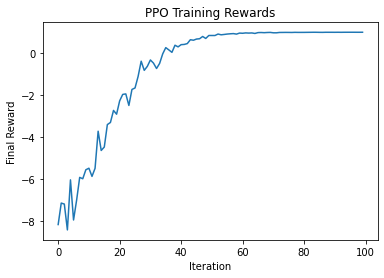

In [13]:
plt.plot(rewards)
plt.xlabel('Iteration')
plt.ylabel('Final Reward')
plt.title('PPO Training Rewards')

# New implementation

In [5]:
from functools import partial

import hydra
from omegaconf import DictConfig, OmegaConf

from renaissance.kinetics.jacobian_solver import check_jacobian

from helpers.ppo_agent import PPOAgent
from helpers.env import KineticEnv
from helpers.utils import reward_func, load_pkl

import logging

def train(cfg: DictConfig):

    print("-" * 50)
    print(OmegaConf.to_yaml(cfg))  # print config to verify
    print("-" * 50)

    # Call solvers from SKimPy
    chk_jcbn = check_jacobian()
    logging.disable(logging.CRITICAL)

    # Integrate data
    print("FYI: Loading kinetic and thermodynamic data.")
    chk_jcbn._load_ktmodels(cfg.paths.met_model_name, 'fdp1') # Load kinetic and thermodynamic data
    chk_jcbn._load_ssprofile(cfg.paths.met_model_name, 'fdp1', cfg.constraints.ss_idx) # Integrate steady state information

    # Logger setup, todo: for now disabled, else we would get w&b run object
    logger = None # get_logger(cfg)

    # Initialize environment
    names_km = load_pkl(cfg.paths.names_km)
    reward_fn = partial(reward_func, chk_jcbn, names_km, cfg.reward.eig_partition)
    env = KineticEnv(cfg, reward_fn)
    env.seed(cfg.seed)

    # Initialize PPO agent (actor and critic)
    ppo_agent = PPOAgent(cfg, logger)
   
    # Training loop
    for episode in range(cfg.training.num_episodes):
        trajectory = ppo_agent.collect_trajectory(env)
        rewards = trajectory["rewards"]
        min_rew, max_rew, mean_rew = rewards.min(), rewards.max(), rewards.mean()
        print(f"Episode {episode+1}/{cfg.training.num_episodes} - Min reward: {min_rew:.4f}, Max reward: {max_rew:.4f}, Mean reward: {mean_rew:.4f}")

        policy_loss, value_loss, entropy = ppo_agent.update(trajectory)
        print(f"Episode {episode+1}/{cfg.training.num_episodes} - Policy loss: {policy_loss:.4f}, Value loss: {value_loss:.4f}, Entropy: {entropy:.4f}")


ModuleNotFoundError: No module named 'helpers.ppo_agent'

In [ ]:
from omegaconf import OmegaConf
import hydra
from hydra import initialize, compose
from renaissance.kinetics.jacobian_solver import check_jacobian

from helpers.ppo_agent import PPOAgent
from helpers.env import KineticEnv
from helpers.utils import reward_func, load_pkl

# Hydra-style manual config loading in a notebook
initialize(config_path="configs", version_base="1.1")

In [49]:
cfg = compose(config_name="train_sandbox.yaml")

In [50]:
print("-" * 50)
print(OmegaConf.to_yaml(cfg))  # print config to verify
print("-" * 50)

# Call solvers from SKimPy
chk_jcbn = check_jacobian()
logging.disable(logging.CRITICAL)

# Integrate data
print("FYI: Loading kinetic and thermodynamic data.")
chk_jcbn._load_ktmodels(cfg.paths.met_model_name, 'fdp1') # Load kinetic and thermodynamic data
chk_jcbn._load_ssprofile(cfg.paths.met_model_name, 'fdp1', cfg.constraints.ss_idx) # Integrate steady state information

--------------------------------------------------
method:
  name: ppo_refinement
  actor_lr: 0.0003
  critic_lr: 0.001
  discount_factor: 0.99
  gae_lambda: 0.98
  clip_eps: 0.2
  value_loss_weight: 0.5
  entropy_loss_weight: 0.0
  parameter_dim: 10
  latent_dim: 99
seed: 42
device: cpu
logger:
  project: rl-renaissance
  entity: ludekcizinsky
  tags:
  - dev
paths:
  names_km: data/varma_ecoli_shikki/parameter_names_km_fdp1.pkl
  output_dir: /home/renaissance/output
  met_model_name: varma_ecoli_shikki
constraints:
  min_km: -25
  max_km: 3
  ss_idx: 1712
reward:
  eig_partition: -2.5
env:
  p0_init_mean: 0
  p0_init_std: 0.1
  p_size: 10
training:
  num_episodes: 1000
  max_steps_per_episode: 50
  batch_size: 25
  num_epochs: 10
  max_grad_norm: 0.5

--------------------------------------------------
FYI: Loading kinetic and thermodynamic data.


Process ForkPoolWorker-251:
Process ForkPoolWorker-250:
Process ForkPoolWorker-226:
Process ForkPoolWorker-240:
Process ForkPoolWorker-246:
Process ForkPoolWorker-242:
Process ForkPoolWorker-244:
Process ForkPoolWorker-238:
Process ForkPoolWorker-256:
Process ForkPoolWorker-227:
Process ForkPoolWorker-253:
Process ForkPoolWorker-239:
Process ForkPoolWorker-255:
Process ForkPoolWorker-225:
Process ForkPoolWorker-254:
Process ForkPoolWorker-236:
Process ForkPoolWorker-234:
Process ForkPoolWorker-235:
Process ForkPoolWorker-237:
Process ForkPoolWorker-249:
Process ForkPoolWorker-245:
Process ForkPoolWorker-233:
Process ForkPoolWorker-228:
Process ForkPoolWorker-243:
Process ForkPoolWorker-248:
Process ForkPoolWorker-231:
Process ForkPoolWorker-241:
Process ForkPoolWorker-247:
Process ForkPoolWorker-232:
Process ForkPoolWorker-230:
Process ForkPoolWorker-229:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call

In [51]:
# Logger setup, todo: for now disabled, else we would get w&b run object
logger = None # get_logger(cfg)

# Initialize environment
names_km = load_pkl(cfg.paths.names_km)
#reward_fn = partial(reward_func, chk_jcbn, names_km, cfg.reward.eig_partition)
reward_fn = compute_reward
env = KineticEnv(cfg, reward_fn)
env.seed(cfg.seed)

In [52]:

# Initialize PPO agent (actor and critic)
ppo_agent = PPOAgent(cfg, logger)

log_rewards = []
# Training loop
for episode in range(cfg.training.num_episodes):
    trajectory = ppo_agent.collect_trajectory(env)
    rewards = trajectory["rewards"]
    min_rew, max_rew, mean_rew = rewards.min(), rewards.max(), rewards.mean()
    print(f"Episode {episode+1}/{cfg.training.num_episodes} - Min reward: {min_rew:.4f}, Max reward: {max_rew:.4f}, Mean reward: {mean_rew:.4f}")
    log_rewards.append(rewards.mean())
    policy_loss, value_loss, entropy = ppo_agent.update(trajectory)
    print(f"Episode {episode+1}/{cfg.training.num_episodes} - Policy loss: {policy_loss:.4f}, Value loss: {value_loss:.4f}, Entropy: {entropy:.4f}")

Episode 1/1000 - Min reward: -37.7796, Max reward: -17.2200, Mean reward: -33.0110
Episode 1/1000 - Policy loss: -0.0047, Value loss: 48.0337, Entropy: 9.1927
Episode 2/1000 - Min reward: -25.9326, Max reward: -18.4748, Mean reward: -23.5164
Episode 2/1000 - Policy loss: -0.0017, Value loss: 69.6841, Entropy: 9.2009
Episode 3/1000 - Min reward: -35.8524, Max reward: -1.6536, Mean reward: -28.6795
Episode 3/1000 - Policy loss: 0.1571, Value loss: 60.2559, Entropy: 9.2047
Episode 4/1000 - Min reward: -27.9694, Max reward: -17.1126, Mean reward: -23.5138
Episode 4/1000 - Policy loss: -0.1401, Value loss: 60.2417, Entropy: 9.2033
Episode 5/1000 - Min reward: -35.3870, Max reward: -16.1418, Mean reward: -24.8544
Episode 5/1000 - Policy loss: -0.1433, Value loss: 39.8032, Entropy: 9.2089
Episode 6/1000 - Min reward: -36.4571, Max reward: -7.5506, Mean reward: -29.7409
Episode 6/1000 - Policy loss: -0.3226, Value loss: 25.2852, Entropy: 9.2231
Episode 7/1000 - Min reward: -35.9217, Max reward

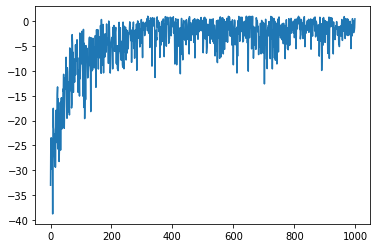

In [53]:
from matplotlib import pyplot as plt

plt.plot(log_rewards)